In [87]:
import pandas as pd


tourism = pd.read_csv('tourism.csv')

tourism['tourism_arrivals'].sort_values(ascending=False)

5579    2.403074e+09
5313    2.339400e+09
5047    2.248871e+09
4781    2.140443e+09
4515    2.071786e+09
            ...     
6645             NaN
6646             NaN
6647             NaN
6648             NaN
6649             NaN
Name: tourism_arrivals, Length: 6650, dtype: float64

<Axes: >

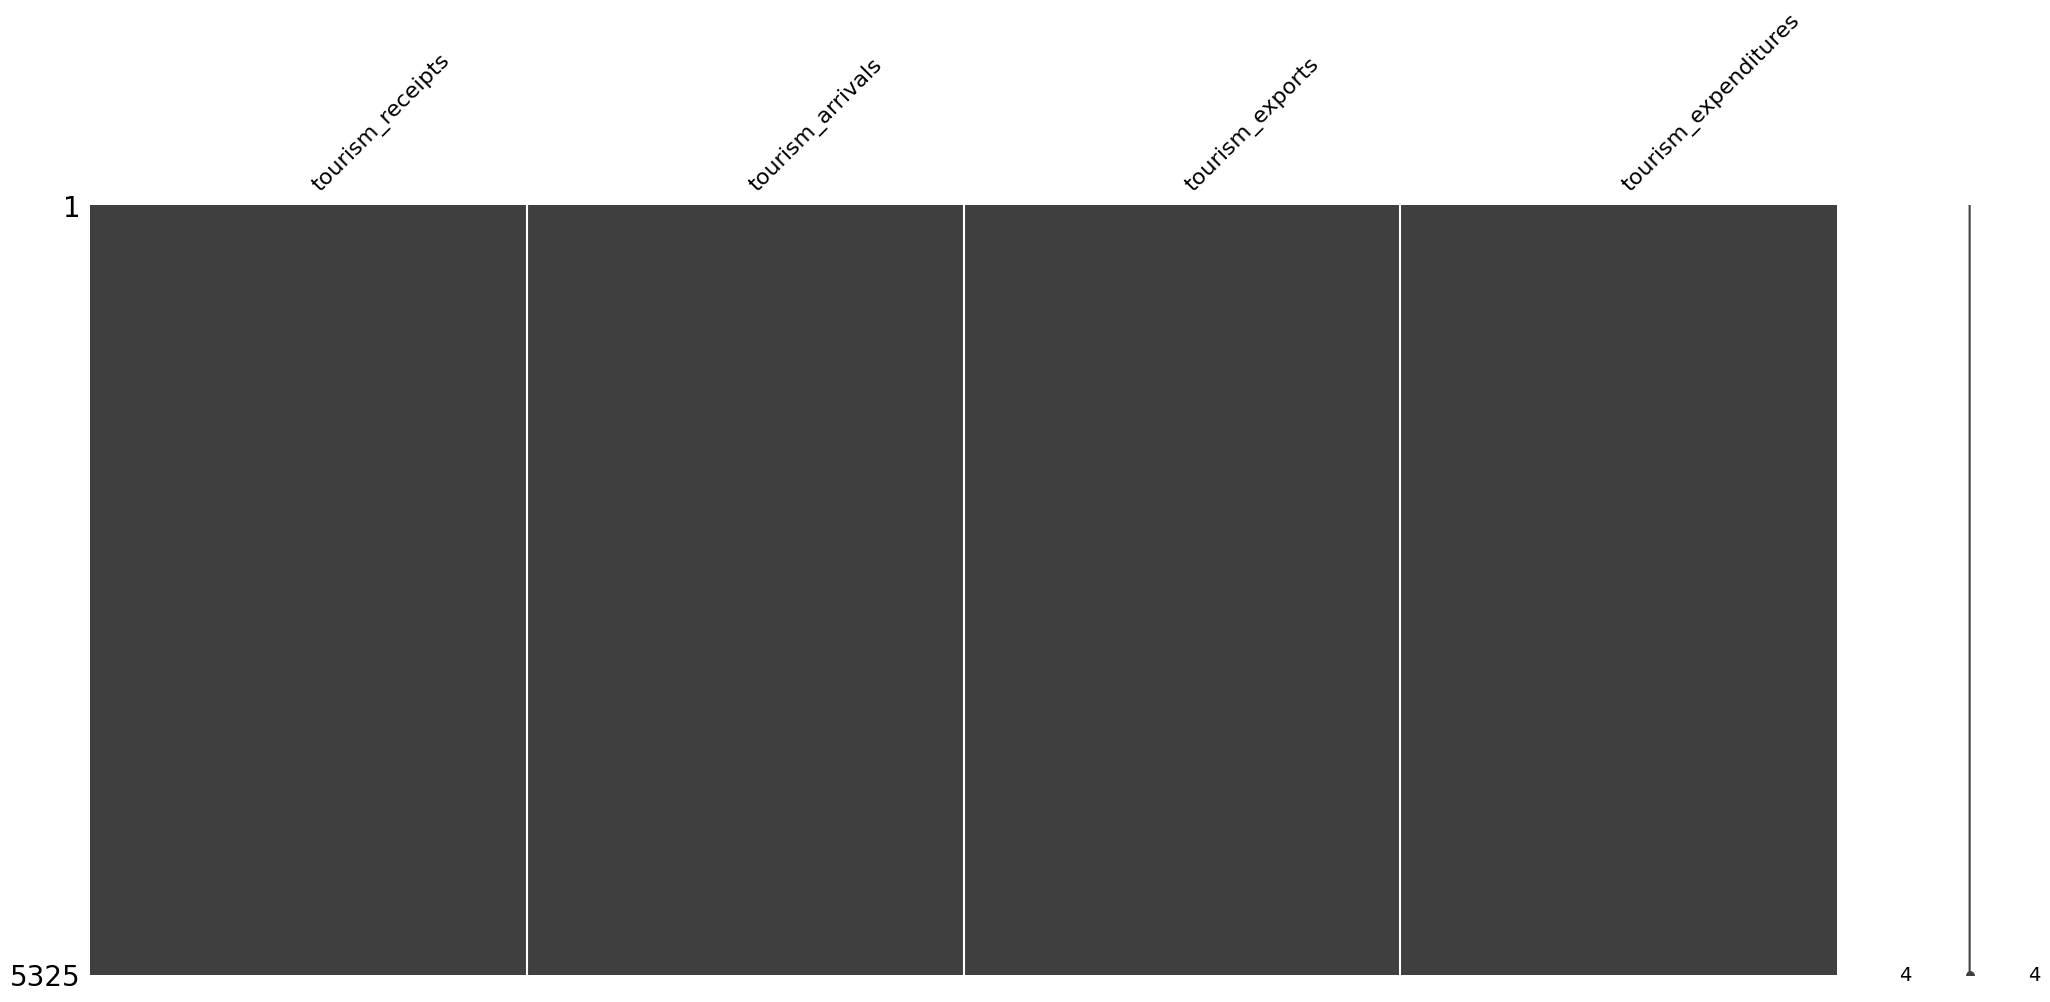

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import miceforest as mf
import missingno as msno
import numpy as np

# Load data
tourism = pd.read_csv('tourism.csv')

# Add continent info
import pycountry_convert as pc
from pycountry import countries

def country_to_continent(code):
    try:
        alpha2 = countries.get(alpha_3=code).alpha_2
        cont_code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(cont_code)
    except:
        return None

tourism['continent'] = tourism['country_code'].apply(country_to_continent)
tourism = tourism.dropna(subset=['continent'])

# Set categories
tourism['country_code'] = tourism['country_code'].astype('category')
tourism['continent'] = tourism['continent'].astype('category')

# Select relevant columns
cols = ['country_code', 'continent', 'year', 'tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures']
tourism = tourism.reset_index(drop=True)


# impute
kernel = mf.ImputationKernel(
    tourism[cols],
    random_state=42
)
kernel.mice(3)

# Get imputed data
completed_df = kernel.complete_data(0)

# Visualize
msno.matrix(completed_df[['tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_expenditures']])


In [77]:
# create groupings of countries by continant
import pycountry_convert as pc

def country_to_continent(country_code):
    try:
        # Convert 3-letter to 2-letter code (if needed)
        from pycountry import countries
        alpha2 = countries.get(alpha_3=country_code).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except Exception as e:
        return None  # or return 'Unknown'

# Apply to the DataFrame
tourism['continent'] = tourism['country_code'].apply(country_to_continent)
tourism = tourism.dropna(subset=['continent'])
tourism


,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,continent
0,Aruba,ABW,1999,782000000.0,972000.0,62.542949,NaN,9.495387,1.722905e+09,2.280372,NaN,North America
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia
4,Angola,AGO,1999,31000000.0,45000.0,0.583858,NaN,2.489638,6.152923e+09,248.195902,NaN,Africa
5,Albania,ALB,1999,218000000.0,371000.0,55.969191,NaN,3.699007,3.212122e+09,0.389438,18.400,Europe
6,Andorra,AND,1999,NaN,9422000.0,NaN,NaN,NaN,1.240295e+09,NaN,NaN,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...
6644,Samoa,WSM,2023,NaN,NaN,NaN,NaN,NaN,9.381894e+08,NaN,NaN,Oceania
6646,"Yemen, Rep.",YEM,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asia
6647,South Africa,ZAF,2023,NaN,NaN,NaN,NaN,NaN,3.806993e+11,6.073909,32.098,Africa
6648,Zambia,ZMB,2023,NaN,NaN,NaN,NaN,NaN,2.757796e+10,10.884532,NaN,Africa
